In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import control

In [3]:
chamber_step_110 = pd.read_csv("temp_50_dt.csv")
chamber_step_80 = pd.read_csv("temp_36_dt.csv")
chamber_step_220 = pd.read_csv("temp_220V.csv")

chamber_step_110_off = pd.read_csv("temp_50_dt_off.csv")
chamber_step_80_off = pd.read_csv("temp_36_dt_off.csv")
chamber_step_220_off = pd.read_csv("temp_220V_off.csv")


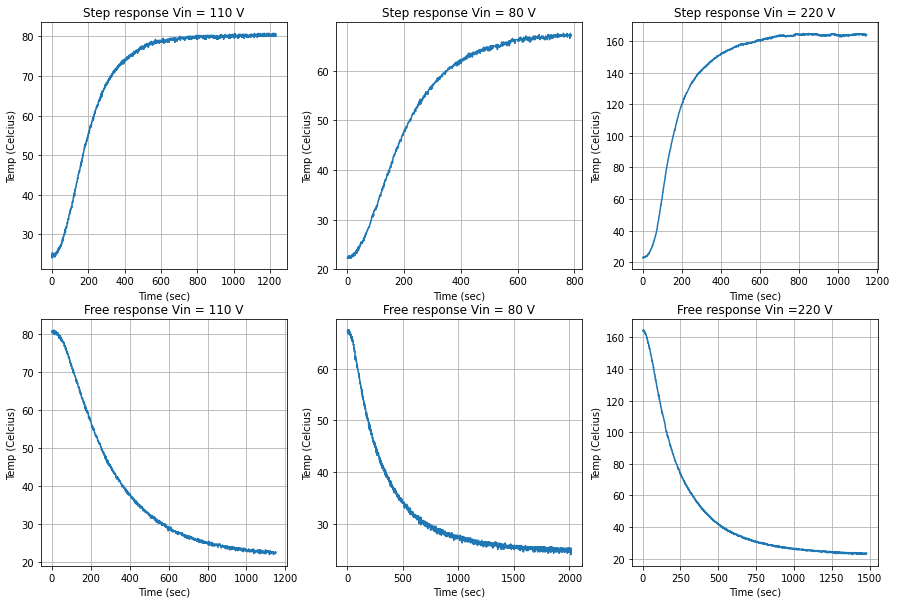

In [4]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Step response Vin = 110 V")
plt.plot(chamber_step_110.iloc[:, 0], chamber_step_110.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 2)
plt.title("Step response Vin = 80 V")
plt.plot(chamber_step_80.iloc[:, 0], chamber_step_80.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 3)
plt.title("Step response Vin = 220 V")
plt.plot(chamber_step_220.iloc[:, 0], chamber_step_220.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 4)
plt.title("Free response Vin = 110 V")
plt.plot(chamber_step_110_off.iloc[:, 0], chamber_step_110_off.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 5)
plt.title("Free response Vin = 80 V")
plt.plot(chamber_step_80_off.iloc[:, 0], chamber_step_80_off.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 6)
plt.title("Free response Vin =220 V")
plt.plot(chamber_step_220_off.iloc[:, 0], chamber_step_220_off.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.show()

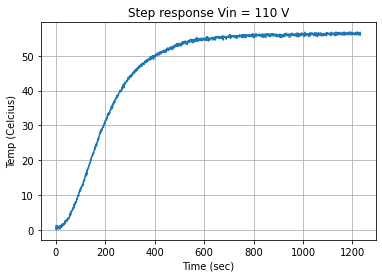

In [5]:
plt.title("Step response Vin = 110 V")
plt.plot(chamber_step_110.iloc[:, 0], np.subtract(chamber_step_110.iloc[:, 1], min(chamber_step_110.iloc[:, 1])))
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

## Identificando o tempo de atrado do sistema

Ao:  12799.416666666657
T + tau:  225.54038179148293
A1:  3421.1666666666665
tau:  163.87128074237538
T:  61.66910104910757


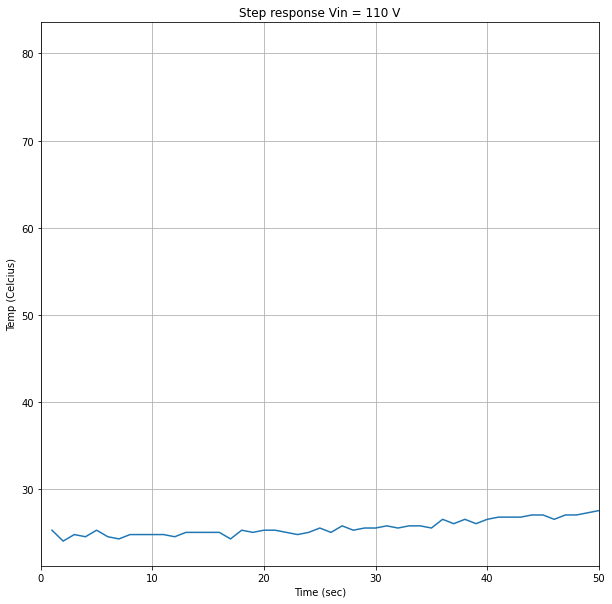

In [6]:
plt.figure(figsize=(10, 10))
plt.title("Step response Vin = 110 V")
plt.plot(chamber_step_110.iloc[:, 0], chamber_step_110.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.xlim(0, 50)
plt.grid()

# Cálulo das áreas para Vin = 110 V
y_t_110 = chamber_step_110.iloc[:, 1]
y_t_110 = np.subtract(y_t_110, min(y_t_110))
k = max(y_t_110)/110
a_zero = simps(np.subtract(k*110, y_t_110))

a_1_lim = a_zero/max(y_t_110)

fs = 1

x_array = np.arange(0, int(a_1_lim), fs)

a_1 = simps(y_t_110[:int(a_1_lim)])

print("Ao: ", a_zero)
print("T + tau: ", a_1_lim)
print("A1: ", a_1)

tau = a_1*np.exp(1)/max(y_t_110)
T = abs(a_zero - a_1*np.exp(1))/max(y_t_110)

print("tau: ", tau)
print("T: ", T)

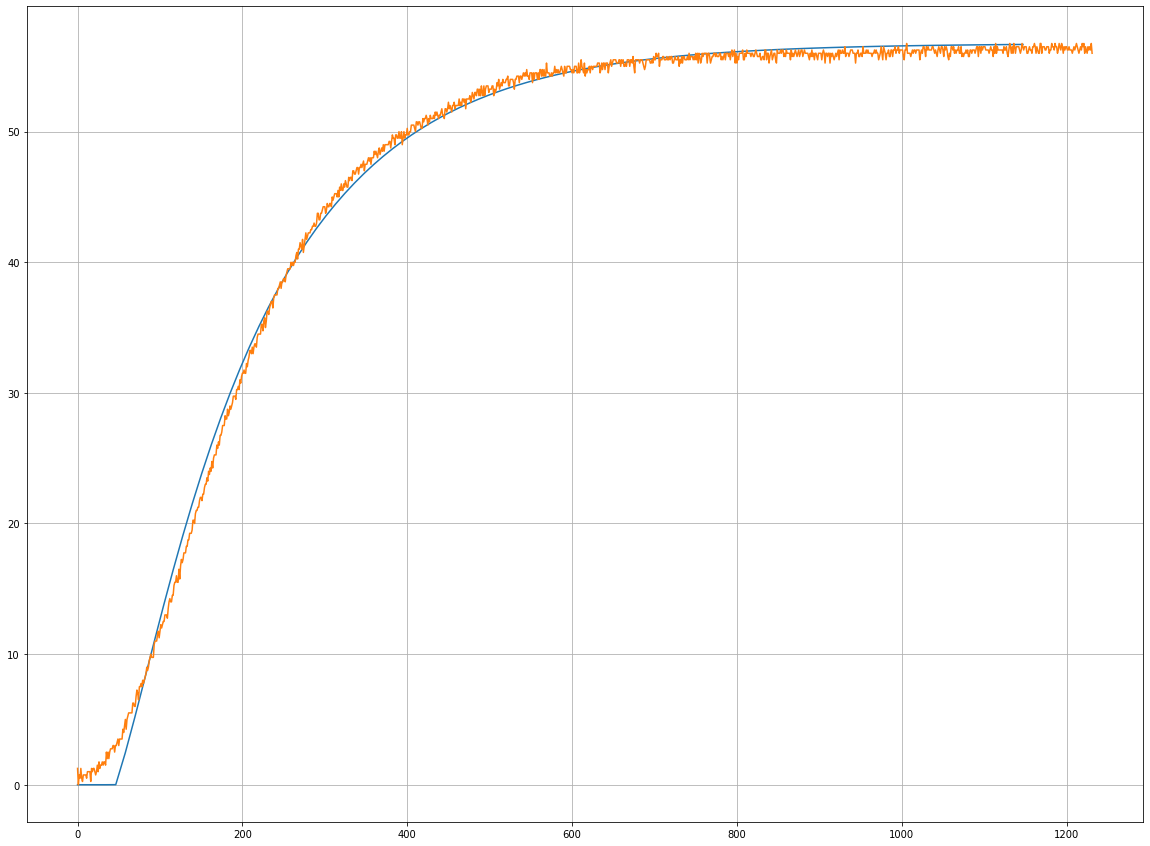

{'RiseTime': 366.29086075848267, 'SettlingTime': 693.5413162950581, 'SettlingMin': 0.46396772823621973, 'SettlingMax': 0.515220566718087, 'Overshoot': 0.0, 'Undershoot': -0.027378351039354633, 'Peak': 0.515220566718087, 'PeakTime': 1147.0989651966277, 'SteadyStateValue': 0.515220566718087}


In [7]:
num, den = control.pade(T, 1)

sys = control.TransferFunction(num, den)
sys_2 = control.TransferFunction([k], [tau, 1])

sys_comp = control.series(sys, sys_2)

t, y = control.step_response(sys_comp)

y = [i*110 if i > 0 else 0 for i in y]


plt.figure(figsize=(20, 15))
plt.plot(t, y)
plt.plot(y_t_110)
plt.grid()
plt.show()

print(control.step_info(sys_comp))

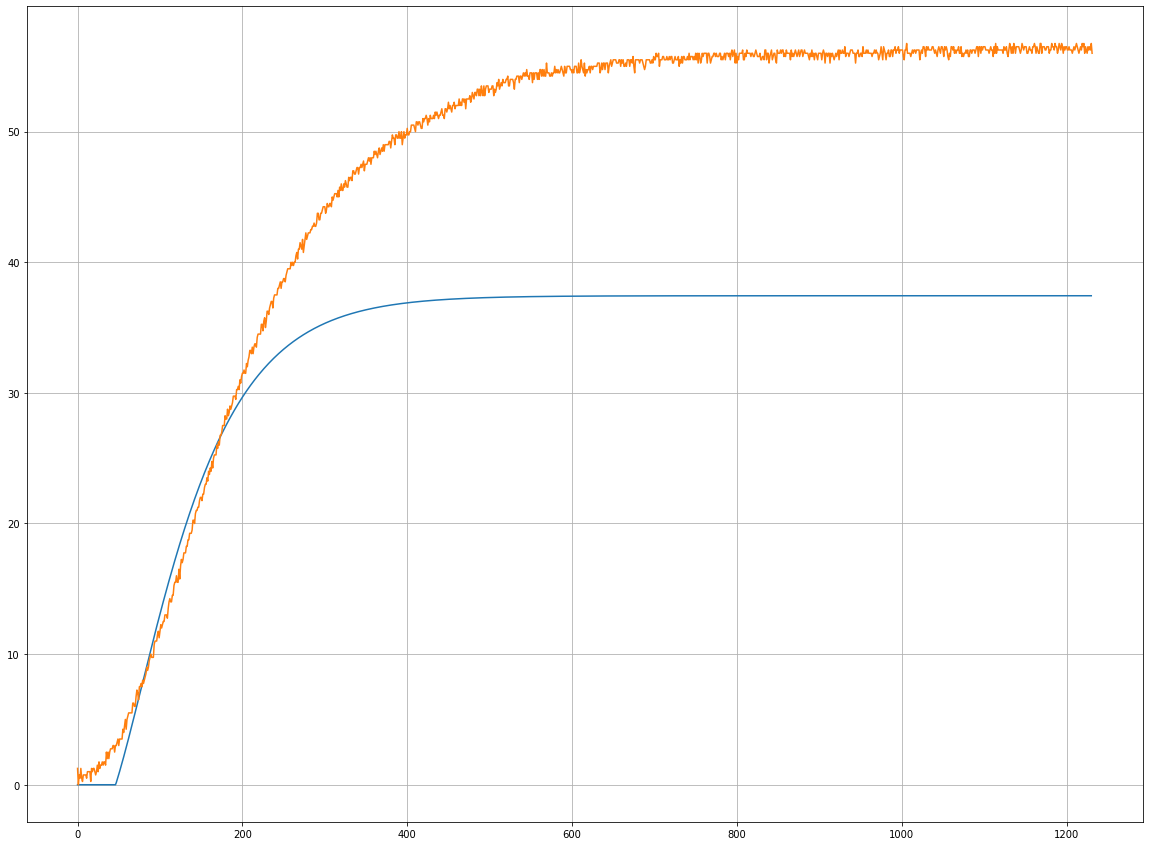

In [8]:
# Comportamento do sistema em malha fechada

sys_feed = control.feedback(sys1=sys_comp, sys2=1)

x = np.arange(0, len(y_t_110)-1)

t, y = control.step_response(sys_feed, x)

y = [i*110 if i > 0 else 0 for i in y]


plt.figure(figsize=(20, 15))
plt.plot(t, y)
plt.plot(y_t_110)
plt.grid()
plt.show()

## PID Design

### Ziegler-Nichols table rules for PID controllers

#### PI
* $K_p$ = $0.9*\frac{T}{L}$ 
* $T_i$ = $\frac{L}{0.3}$ 
* $T_d$ = 0

#### PID
* $K_p$ = $1.2*\frac{T}{L}$ 
* $T_i$ = $2*L$ 
* $T_d$ = $0.5*L$

In [64]:
# PID Tunning
Kp = 1.3 * tau/T
Ti = 3 * T
Td = 0.5 * T

P = control.TransferFunction(Kp, 1) 
I = control.TransferFunction(Kp, [Ti, 0])
D = control.TransferFunction([Kp*Td, 0], 1)

PID = P + I + D

#PI Tunning
Kp_pi = 0.9* tau/T
Ti_pi = T/.3

P_pi = control.TransferFunction(Kp_pi, 1)
I_pi = control.TransferFunction(Kp_pi, [Ti_pi, 0])

PI = P_pi + I_pi

print(PID)
print(PI)


1.971e+04 s^2 + 639.1 s + 3.454
-------------------------------
             185 s


491.6 s + 2.392
---------------
    205.6 s



0.5159090909090909


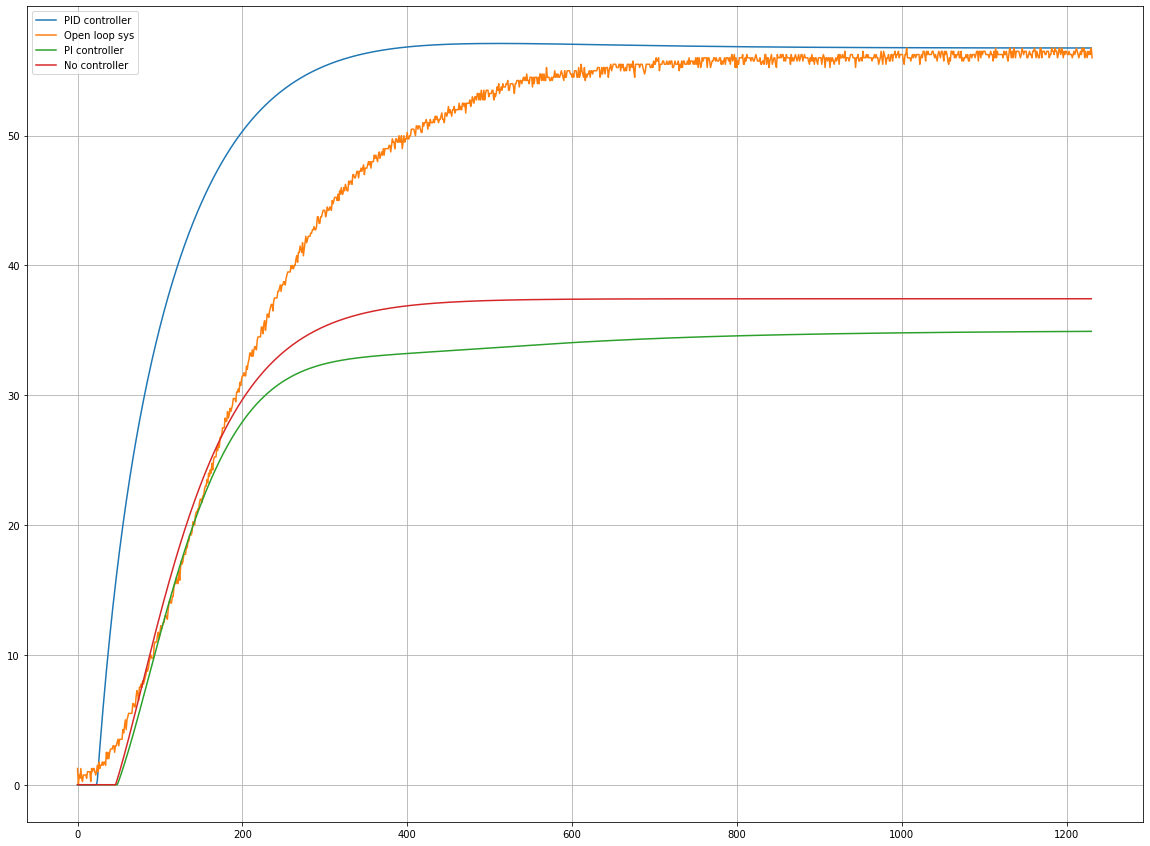

In [65]:
sys_PID = control.series(PID, sys_comp)
sys_fb = control.feedback(sys_PID, 1)

t, y = control.step_response(sys_fb, x)

y = [i*k*110 if i > 0 else 0 for i in y]


plt.figure(figsize=(20, 15))
plt.plot(t, y)
plt.plot(y_t_110)

print(k)

sys_PI = control.series(PI, sys_comp)
sys_fb_pi = control.feedback(sys_PI, 1)

t, y = control.step_response(sys_fb_pi, x)

y_pi = [i*35 if i > 0 else 0 for i in y]

plt.plot(t, y_pi)
plt.grid()

t, y = control.step_response(sys_feed, x)

y = [i*110 if i > 0 else 0 for i in y]

plt.plot(t, y)
plt.legend(['PID controller', 'Open loop sys', 'PI controller', 'No controller'])
plt.show()

In [56]:
print(Kp, Ti, Td)
print(Kp_pi, Ti_pi)

3.1887206647338693 123.33820209821513 30.834550524553784
2.3915404985504023 205.5636701636919


In [66]:
print(Kp_pi/Ti_pi)
print("Kp: ", Kp, "\nKi: ", Kp/Ti, "\nKd: ", Kp*Td)

0.011634062072573429
Kp:  3.4544473867950254 
Ki:  0.018671951474500566 
Kd:  106.516332482544
